In [37]:
import os
import json
import pandas as pd
from tqdm import tqdm

json_folder = r"C:\Users\admin\Desktop\AI in Healthcare\Research Project\All Converted Files"
observations = []

for filename in tqdm(os.listdir(json_folder)):
    if filename.endswith(".json"):
        path = os.path.join(json_folder, filename)
        try:
            with open(path) as f:
                bundle = json.load(f)
                for entry in bundle.get("entry", []):
                    resource = entry.get("resource", {})
                    if resource.get("resourceType") == "Observation":
                        patient_ref = resource.get("subject", {}).get("reference", "")
                        patient_id = patient_ref.split("/")[-1] if patient_ref else None
                        raw_time = resource.get("effectiveDateTime")

                        if patient_id and raw_time:
                            ts = pd.to_datetime(raw_time, errors='coerce', utc=True)
                            ts_naive = ts.tz_convert(None) if ts.tzinfo else ts
                            observations.append({
                                "patient_id": patient_id,
                                "timestamp": ts_naive,
                                "file": filename
                            })
        except Exception as e:
            print(f"Error reading {filename}: {e}")


100%|██████████████████████████████████████████████████████████████████████████████| 2104/2104 [00:25<00:00, 83.85it/s]


In [38]:
# Create DataFrame
obs_df = pd.DataFrame(observations)

# Drop rows with missing timestamps
obs_df = obs_df.dropna(subset=["timestamp"])

# Convert patient ID to string (for grouping)
obs_df["patient_id"] = obs_df["patient_id"].astype(str)

# Sort by patient and timestamp safely
obs_df = obs_df.sort_values(by=["patient_id", "timestamp"]).reset_index(drop=True)

# Preview
print(f"Total observations extracted: {len(obs_df)}")
obs_df.head()


Total observations extracted: 39649


,patient_id,timestamp,file
0,000000001,2024-10-11 01:01:00,fhir_output_TEST_ccd_uphealthsystem-marquette_...
1,000000001,2024-10-11 01:01:00,fhir_output_TEST_ccd_uphealthsystem-marquette_...
2,000000001,2024-10-11 01:04:01,fhir_output_TEST_ccd_uphealthsystem-marquette_...
3,000000001,2024-10-11 03:35:00,fhir_output_TEST_ccd_uphealthsystem-marquette_...
4,000000001,2024-10-11 03:35:00,fhir_output_TEST_ccd_uphealthsystem-marquette_...


In [39]:
# Start with no readmissions
obs_df["readmitted"] = 0

# Loop through observations by same patient
for i in range(1, len(obs_df)):
    prev = obs_df.iloc[i - 1]
    curr = obs_df.iloc[i]

    if curr["patient_id"] == prev["patient_id"]:
        days_apart = (curr["timestamp"] - prev["timestamp"]).days
        if 0 < days_apart <= 30:
            obs_df.at[i, "readmitted"] = 1


In [40]:
# If patient was readmitted at least once → label = 1
patient_labels = obs_df.groupby("patient_id")["readmitted"].max().reset_index()

# Convert patient_id to string to match feature dataset
patient_labels["patient_id"] = patient_labels["patient_id"].astype(str)

# Preview the readmission label distribution
print("Readmission Label Counts:")
print(patient_labels["readmitted"].value_counts())

patient_labels.head()


Readmission Label Counts:
readmitted
0    200
1    152
Name: count, dtype: int64


,patient_id,readmitted
0,000000001,1
1,000000003,1
2,000000004,0
3,000000005,1
4,000000007,1


In [41]:
import pandas as pd

# Load your modeling dataset
df_main = pd.read_csv("readmission_dataset2.csv")

# Ensure both patient IDs are strings for a safe merge
df_main["patient_id"] = df_main["patient_id"].astype(str)
patient_labels["patient_id"] = patient_labels["patient_id"].astype(str)

# Merge real readmission labels
df_labeled = df_main.merge(patient_labels, on="patient_id", how="left")

# Patients not found in readmission label → assume not readmitted
df_labeled["readmitted"] = df_labeled["readmitted"].fillna(0).astype(int)

# Confirm success
print("Readmission label counts after merge:")
print(df_labeled["readmitted"].value_counts())
df_labeled.head()


Readmission label counts after merge:
readmitted
0    320
1    158
Name: count, dtype: int64


,patient_id,gender,age,num_conditions,num_encounters,chronic_conditions,Height,Glucose_avg,Temperature,SystolicBP,DiastolicBP,HeartRate,HemoglobinA1C,Weight,BMI,readmitted
0,106,female,61.0,4,2,NaN,129.666667,156.0,36.80,115.000000,76.666667,99.333333,11.6,NaN,NaN,0
1,109,female,80.0,36,4,NaN,157.500000,NaN,36.86,131.250000,92.250000,94.000000,NaN,48.762,19.6625,1
2,107,male,39.0,10,1,NaN,162.600000,NaN,36.56,131.000000,84.000000,114.000000,NaN,65.318,24.7200,0
3,212,NaN,NaN,2,1,Asthma; Hypertension,190.000000,NaN,37.20,175.000000,91.000000,NaN,NaN,NaN,NaN,0
4,148,male,27.0,15,2,Depression,173.600000,NaN,36.97,112.571429,63.857143,65.142857,NaN,115.667,39.9400,0


In [42]:
# Drop text columns not used in modeling (optional: add more if needed)
df_model = df_labeled.drop(columns=["patient_id", "birthDate", "num_encounters", "address", "name"], errors='ignore')


In [43]:
# Map gender manually
if "gender" in df_model.columns:
    df_model["gender"] = df_model["gender"].map({"female": 1, "male": 0})

# Automatically one-hot encode remaining object columns
non_numeric = df_model.select_dtypes(include='object').columns.tolist()
if non_numeric:
    print("One-hot encoding:", non_numeric)
    df_model = pd.get_dummies(df_model, columns=non_numeric, drop_first=True)


One-hot encoding: ['chronic_conditions']


In [44]:
from sklearn.impute import SimpleImputer

# Use SimpleImputer to fill remaining NaNs
imputer = SimpleImputer(strategy="median")
df_model_imputed = pd.DataFrame(
    imputer.fit_transform(df_model),
    columns=df_model.columns
)

# Confirm no NaNs remain
print("NaNs after imputation:", df_model_imputed.isnull().sum().sum())


NaNs after imputation: 0


In [45]:
from sklearn.model_selection import train_test_split

X = df_model_imputed.drop(columns=["readmitted"])
y = df_model_imputed["readmitted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [46]:
from sklearn.utils import resample
import numpy as np

# Combine for resampling
train_df = pd.concat([X_train, y_train], axis=1)

# Split by class
majority = train_df[train_df["readmitted"] == 0]
minority = train_df[train_df["readmitted"] == 1]

# Upsample minority to match majority
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)

# Combine and shuffle
balanced_df = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42)

# Separate again
X_res = balanced_df.drop(columns=["readmitted"])
y_res = balanced_df["readmitted"]

print("Balanced class distribution:", np.bincount(y_res))


Balanced class distribution: [256 256]


In [47]:
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Optional: try XGBoost if installed
try:
    from xgboost import XGBClassifier
except:
    XGBClassifier = None

# Define models dictionary
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP Neural Net": MLPClassifier(max_iter=1000)
}

if XGBClassifier:
    models["XGBoost"] = XGBClassifier(eval_metric='logloss', enable_categorical=False)


In [48]:
import warnings
warnings.filterwarnings("ignore")


from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)

results = []

for name, model in models.items():
    print(f"\nEvaluating: {name}")
    try:
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)

        # Use predicted probabilities for AUC if available
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = y_pred

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba)

        print(f"Accuracy: {acc:.3f}")
        print(f"F1 Score: {f1:.3f}")
        print(f"AUROC: {auc:.3f}")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

        results.append({"Model": name, "Accuracy": acc, "F1 Score": f1, "AUROC": auc})

    except Exception as e:
        print(f"{name} failed: {e}")



Evaluating: Random Forest
Accuracy: 0.760
F1 Score: 0.623
AUROC: 0.828
Confusion Matrix:
 [[54 10]
 [13 19]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.84      0.82        64
         1.0       0.66      0.59      0.62        32

    accuracy                           0.76        96
   macro avg       0.73      0.72      0.72        96
weighted avg       0.76      0.76      0.76        96


Evaluating: Logistic Regression
Accuracy: 0.656
F1 Score: 0.459
AUROC: 0.648
Confusion Matrix:
 [[49 15]
 [18 14]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.77      0.75        64
         1.0       0.48      0.44      0.46        32

    accuracy                           0.66        96
   macro avg       0.61      0.60      0.60        96
weighted avg       0.65      0.66      0.65        96


Evaluating: Gradient Boosting
Accuracy: 0.729
F1 Score: 0.594
AUROC: 0.

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score
# Define models + hyperparameter grids
model_configs = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {"C": [0.1, 1, 10], "solver": ["liblinear", "lbfgs"]}
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {"n_estimators": [100, 200], "max_depth": [5, 10]}
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        {"n_estimators": [100, 200], "max_depth": [3, 6]}
    ),
    "SVM": (
        SVC(probability=True),
        {"C": [0.1, 1], "kernel": ["linear", "rbf"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7]}
    ),
    "Naive Bayes": (
        GaussianNB(),
        {}  # No tuning
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(),
        {"n_estimators": [100, 200], "max_depth": [3, 6]}
    ),
    "MLP": (
        MLPClassifier(max_iter=500),
        {"hidden_layer_sizes": [(50,), (100,)], "activation": ["relu", "tanh"]}
    )
}

# Tune + evaluate
models = {}
results = {}

for name, (model, params) in model_configs.items():
    print(f"Tuning {name}...")
    clf = GridSearchCV(model, params, scoring="roc_auc", cv=3, n_jobs=-1)
    clf.fit(X_train, y_train)
    best = clf.best_estimator_
    models[name] = best

    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)[:, 1]

    results[name] = {
        "F1": f1_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "AUROC": roc_auc_score(y_test, y_prob)
    }


Tuning Logistic Regression...
Tuning Random Forest...
Tuning XGBoost...
Tuning SVM...
Tuning KNN...
Tuning Naive Bayes...
Tuning Gradient Boosting...
Tuning MLP...


In [50]:
import pandas as pd

# Create summary table (transpose first)
results_df = pd.DataFrame(results).T.sort_values(by="AUROC", ascending=False).reset_index()

# Rename for clarity
results_df.rename(columns={'index': 'Model'}, inplace=True)

# Display
print("Final Model Comparison:")
display(results_df)


Final Model Comparison:


,Model,F1,Recall,AUROC
0,Gradient Boosting,0.688525,0.65625,0.870117
1,Random Forest,0.677419,0.65625,0.861816
2,XGBoost,0.593750,0.59375,0.805176
3,MLP,0.590164,0.56250,0.798828
4,SVM,0.222222,0.12500,0.796875
5,Naive Bayes,0.520000,0.40625,0.776855
6,KNN,0.500000,0.43750,0.763184
7,Logistic Regression,0.390244,0.25000,0.708496



Confusion Matrix for Random Forest:


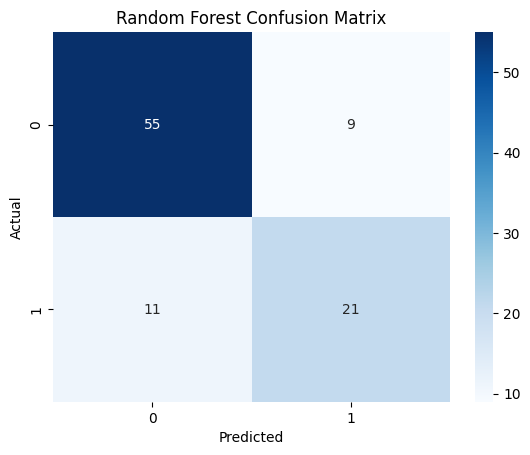

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
print("\nConfusion Matrix for Random Forest:")
cm = confusion_matrix(y_test, models["Random Forest"].predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

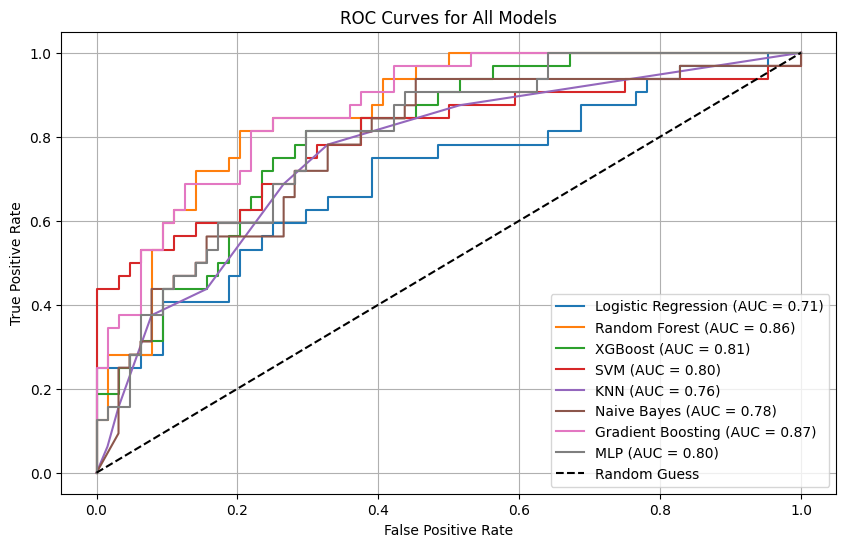

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 6))

for name, model in models.items():
    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    except:
        continue

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()


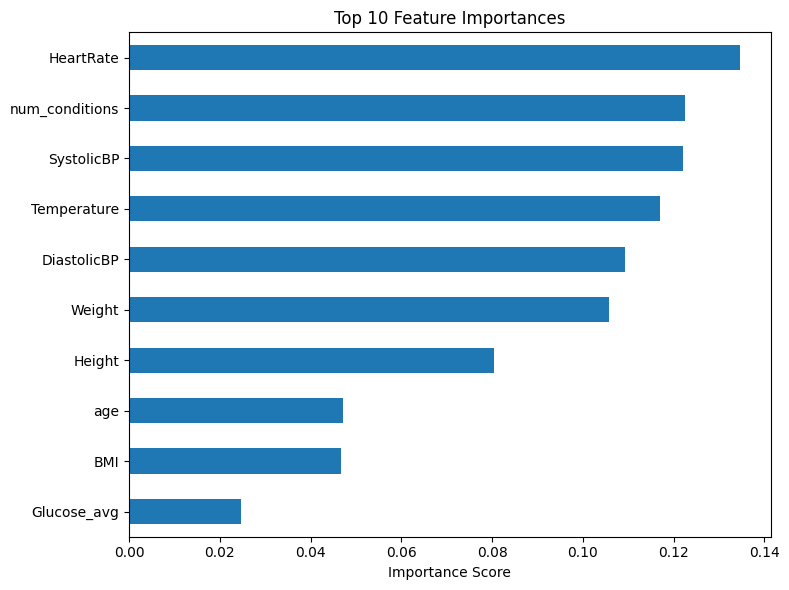

In [53]:
# Must match the model that supports .feature_importances_
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_

# Create a Series for plotting
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Plot top 10 features
feat_imp.head(10).plot(kind="barh", figsize=(8, 6), title="Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
